The CIElab space is more uniform and might be easier to learn than RGB (https://wiki.ubc.ca/Image_Colourization_using_Deep_Learning, https://arxiv.org/pdf/1902.00267.pdf) i'm not sure though with the whitepoint issue. Constraining would require to use the functional API to use different acitvation functions for the different output channels due to the different range of L, and a/b in LAB space. 

In [11]:
import numpy as np 
import pandas as pd 
import time
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel as C)

import joblib

from xgboost import XGBRegressor

import tensorflow as tf
from keras.layers import Dropout, Dense, BatchNormalization, GaussianDropout, GaussianNoise, LeakyReLU
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)
from keras import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#from livelossplot.keras import PlotLossesCallback
from keras.constraints import MinMaxNorm
from keras.initializers import Constant
from keras.optimizers import Adam

from colour.models import RGB_to_XYZ, XYZ_to_xy, XYZ_to_Lab, XYZ_to_RGB, Lab_to_XYZ, RGB_to_HSL, HSL_to_RGB
from colour.plotting import filter_RGB_colourspaces
from colour.utilities import first_item

colourspace = first_item(filter_RGB_colourspaces('sRGB').values())

import matplotlib.pyplot as plt 
%matplotlib inline

import sys
sys.path.append('../')
from colorml.utils import mapping_to_target_range, get_timestamp_string, plot_predictions, huber_fn, mapping_to_target_range_sig
from colorml.descriptornames import * 

RESULTS = os.path.join('..', 'results', 'colorspace')
MODELS = os.path.join('..', 'models', 'colorspace')
from numpy.random import seed
seed(821996)

In [16]:
CHEMICAL_FEATURES = mol_desc + metalcenter_descriptors + functionalgroup_descriptors + linker_descriptors   + summed_linker_descriptors + summed_metalcenter_descriptors + summed_functionalgroup_descriptors

In [17]:
df_subset_merged = pd.read_csv('../data/color_feat_merged.csv')

In [18]:
X_df = df_subset_merged[CHEMICAL_FEATURES]
y_df = df_subset_merged[['r', 'g', 'b']]
X_train, X_test, y_train, y_test, name_train, name_test = train_test_split(X_df, y_df, df_subset_merged['color_cleaned'], train_size=0.7)

### XYZ

In [19]:
y_train_hsl = RGB_to_HSL(y_train)
y_test_hsl = RGB_to_HSL(y_test)

/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/colour/models/rgb/deprecated.py:260: RuntimeWarning: invalid value encountered in true_divide
  delta / (maximum + minimum),
/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/colour/models/rgb/deprecated.py:265: RuntimeWarning: invalid value encountered in true_divide
  delta_R = (((maximum - R) / 6) + (delta / 2)) / delta
/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/colour/models/rgb/deprecated.py:266: RuntimeWarning: invalid value encountered in true_divide
  delta_G = (((maximum - G) / 6) + (delta / 2)) / delta
/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/colour/models/rgb/deprecated.py:267: RuntimeWarning: invalid value encountered in true_divide
  delta_B = (((maximum - B) / 6) + (delta / 2)) / delta
/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/colour/models/rgb/de

In [28]:
N=4
timestamp = get_timestamp_string()
knn = KNeighborsRegressor(N)
pipe = Pipeline(
    [   
        ('vt', VarianceThreshold(0.8)),
        ('knn', knn)
    ]
)


pipe.fit(X_train, y_train_hsl)
joblib.dump(pipe, os.path.join(MODELS, '_'.join([timestamp, 'knn__hsl_{}.joblib'.format(N)])))

['../models/colorspace/Mar-17-2020_1622_knn__hsl_4.joblib']

../colorml/utils.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


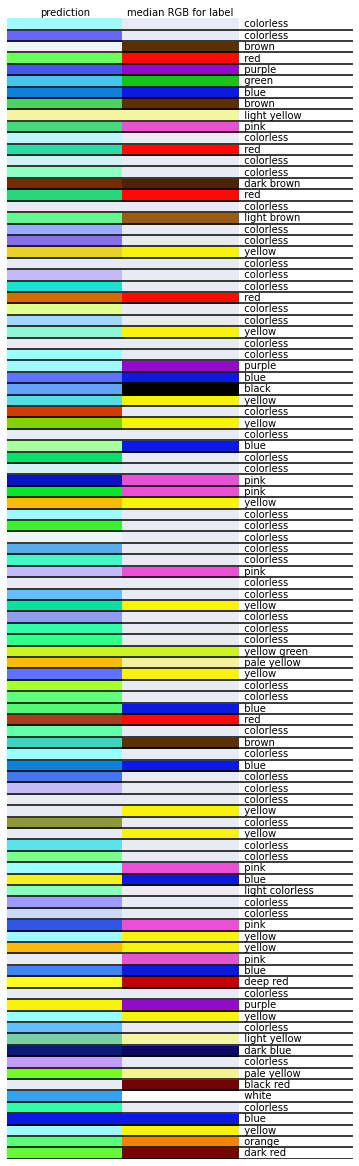

In [29]:
predictions = pipe.predict(X_test)
predictions = HSL_to_RGB(predictions)


plot_predictions(predictions, y_test.values,  name_test.values,  sample=100, outname=os.path.join(MODELS, '_'.join([timestamp, 'knn_xyz_{}_TRAIN.pdf'.format(N)])))

## LAB space

In [44]:
y_train_lab = XYZ_to_Lab(y_train_xyz)
y_test_lab = XYZ_to_Lab(y_test_xyz)

In [45]:
N=2
timestamp = get_timestamp_string()
knn = KNeighborsRegressor(N)
pipe = Pipeline(
    [   
        ('vt', VarianceThreshold(0.8)),
        ('knn', knn)
    ]
)


pipe.fit(X_train, y_train_lab)
joblib.dump(pipe, os.path.join(MODELS, '_'.join([timestamp, 'knn__lab_{}.joblib'.format(N)])))

['../models/colorspace/Feb-26-2020_1234_knn__lab_2.joblib']

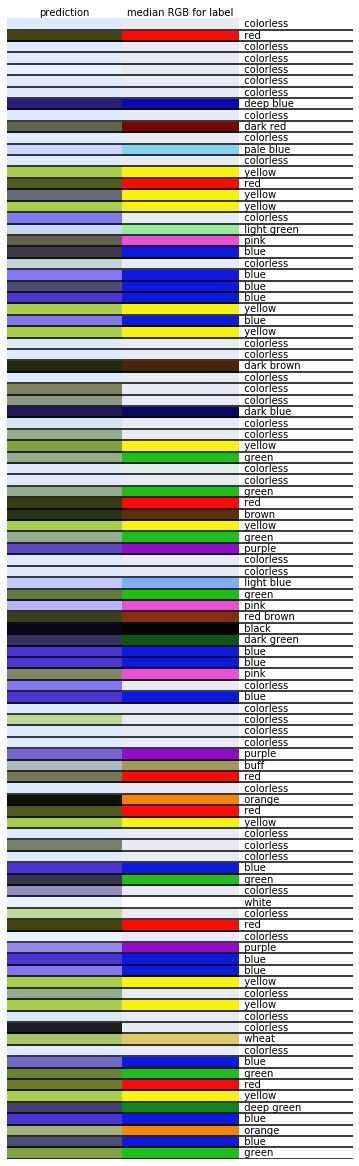

In [48]:
predictions = pipe.predict(X_train)
predictions = XYZ_to_RGB(Lab_to_XYZ(predictions), colourspace.whitepoint, colourspace.whitepoint,
                            colourspace.RGB_to_XYZ_matrix)


plot_predictions(predictions, y_train.values,  name_train.values,  sample=100, outname=os.path.join(MODELS, '_'.join([timestamp, 'knn_lab_{}_TRAIN.pdf'.format(N)])))

In [30]:
gp_kernel =   RBF(1, (1e-3, 1e2)) + C(0, (1e-1, 1e1))
gp = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=2)

gp_pipe = Pipeline(
    [
        ('vt', VarianceThreshold(0.7)), 
        ('gp', gp)
    ]
)

gp_pipe.fit(X_train, y_train_hsl)

/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Pipeline(memory=None,
         steps=[('vt', VarianceThreshold(threshold=0.7)),
                ('gp',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=RBF(length_scale=1) + 0**2,
                                          n_restarts_optimizer=2,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)

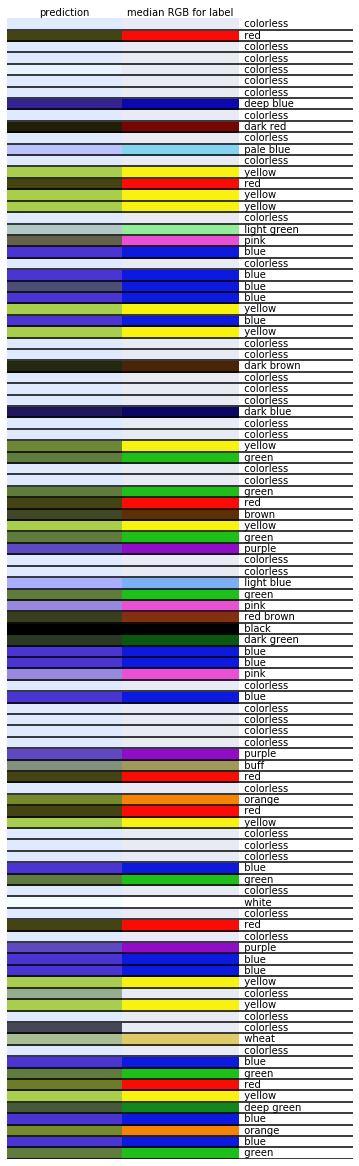

In [50]:
predictions = gp_pipe.predict(X_train)
predictions = XYZ_to_RGB(Lab_to_XYZ(predictions), colourspace.whitepoint, colourspace.whitepoint,
                            colourspace.RGB_to_XYZ_matrix)


plot_predictions(predictions, y_train.values,  name_train.values,  sample=100, outname=os.path.join(MODELS, '_'.join([timestamp, 'gp_lab_{}_TRAIN.pdf'.format(N)])))

In [77]:
timestamp = get_timestamp_string()
mlp = Sequential()
mlp.add(GaussianNoise(0.2, input_shape=(X_train.shape[1],)))
mlp.add(Dense(64, activation=lrelu, 
              kernel_initializer='he_normal'))
mlp.add(GaussianDropout(0.2))
mlp.add(Dense(32,  activation=lrelu, 
             kernel_initializer='he_normal'))  
mlp.add(GaussianDropout(0.2))
mlp.add(Dense(16,  activation=lrelu, 
             kernel_initializer='he_normal'))  
mlp.add(GaussianDropout(0.2))
mlp.add(Dense(8,  activation=lrelu, 
             kernel_initializer='he_normal'))
mlp.add(Dense(3, activation='linear', kernel_initializer='he_normal'))


In [82]:
es = EarlyStopping(monitor='val_loss', patience=40, verbose=0, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=20, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)



In [83]:
mlp.compile(optimizer=Adam(learning_rate=4e-3), loss=huber_fn, metrics=['mae', 'mean_absolute_percentage_error'])

In [84]:
mlp.fit(X_train, y_train_lab, epochs=500, batch_size=50, callbacks=[learning_rate_reduction, es, PlotLossesCallback(plot_extrema=False), tbCallBack], validation_split=0.2)

Train on 4128 samples, validate on 1032 samples


AttributeError: 'Sequential' object has no attribute '_get_distribution_strategy'